In [13]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/maurizio/Documents/projects/coronavirus")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import src.tools as tools
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import scipy.integrate as integrate
from src.data_downloader import DATA_REPOS, download_from_repo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### update data from repos

In [2]:
dest='/home/maurizio/Documents/projects/coronavirus/data'

In [3]:
DATA_REPOS

{'world': {'url': 'https://github.com/CSSEGISandData/COVID-19',
  'streams': {'deaths': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
   'confirmed': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
   'recovered': '/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'}},
 'italy': {'url': 'https://github.com/pcm-dpc/COVID-19',
  'streams': {'andamento-nazionale': '/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
   'regioni': '/dati-regioni/dpc-covid19-ita-regioni.csv',
   'province': '/dati-province/dpc-covid19-ita-province.csv'}}}

In [4]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['deaths'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['confirmed'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['recovered'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['andamento-nazionale'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['regioni'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['province'], 
                   dest='/home/maurizio/Documents/projects/coronavirus/data')

## SIRD Model definition

In [17]:
# SIR model differential equations
def SIR_deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SIR_deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


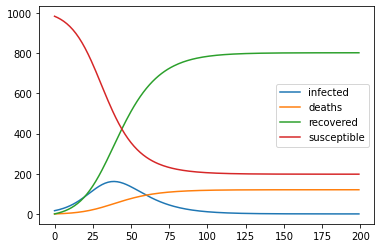

In [18]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  -2.3908903908300796
gamma:  -2.624675267850694
theta:  0.0017962257302843534
r0:  0.9115519062965314
mean period of time of infection:  -0.3809995134441468
max number of infections  281789.17634056613
max number of deaths  8362.413669763124
mae  39.55046752641027


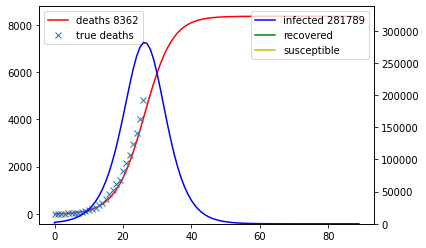

In [19]:
use_differential_evolution = True
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(-5,5), (-5, 5), (-5, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/(params[1]+params[2]))
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots()
ax1.plot(D,'r', label='deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='infected '+str(int(np.max(I))))
ax2.plot(R,'g', label='recovered')
ax2.plot(S,'y', label='susceptible')


ax2.legend()

## SEIR Model definition

In [9]:
def SEIRModel(t, S0, E0, I0, R0, r0, dur_inf, dur_inc):
    # SEIR model differential equations
    def SEIR_deriv(y, t, r0, dur_inf, dur_inc):
        S, E, I, R = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * gamma
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt
    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over time t
    ret = odeint(SEIR_deriv, y0, t, args=(r0, dur_inf, dur_inc))
    S, E, I, R = ret.T
    return S, E, I, R

def calibrate_SEIR(y_fit,
                   N,
                   I0,
                   R0 = 0,
                   E0 = 0,
                   time_horizon = 365,
                   bounds= [(0,5), (1, 30), (1, 30)],
                   use_differential_evolution = True):
    
    # SEIR model differential equations
    def SEIR_deriv(y, t, r0, dur_inf, dur_inc):
        S, E, I, R = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * gamma
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    def SEIRModel_solver(t, r0, dur_inf, dur_inc):
        # Initial conditions vector
        y0 = S0, E0, I0, R0
        # Integrate the SIR equations over time t
        ret = odeint(SEIR_deriv, y0, t, args=(r0, dur_inf, dur_inc))
        S, E, I, R = ret.T
        return I

    def diff_ev_solver(params):
        r0, dur_inf, dur_inc = params
        return np.mean(np.abs(SEIRModel_solver(x_fit, r0, dur_inf, dur_inc) - y_fit))    
    
    x_fit = np.linspace(0, len(y_fit), len(y_fit))
    S0 = N - I0 - R0 - E0 # Initial susceptible population to infection.
    if use_differential_evolution:
        print('calibrating with genetic algorithm...')
        optimization = differential_evolution(diff_ev_solver, bounds, popsize=150, maxiter=10000)
        params = optimization.x
    else:
        params, _ = curve_fit(f=SEIRModel_solver, xdata=x_fit, ydata=y_fit,
                                method='trf', bounds=bounds[0])
    r0, dur_inf, dur_inc = params
    print('r0', params[0])
    print('infection period in days', params[1])
    print('incubation period in days', params[2])
    print('mae ',int(np.mean(np.abs(y_fit-SEIRModel_solver(x_fit, *params)))))
    return r0, dur_inf, dur_inc

def plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc, y = None):
    
    S0 = N - I0 - R0 - E0
    S, E, I, R = SEIRModel(time_range, S0, E0, I0, R0, r0, dur_inf, dur_inc)
    print('max number of infections ', int(np.max(I)))
    print('peak of infections ', np.argmax(I))
    print('max number of exposed ', int(np.max(E)))
    print('max number of recovered ', int(np.max(R)))
    
    fig, ax1 = plt.subplots()
    if y is not None:
        ax1.plot(y,'x', label='actual infected')
    ax1.plot(I,'b', label='infected - max '+str(int(np.max(I))))
    #ax1.plot(R,'g', label='recovered')
    #x1.plot(E,'y', label='exposed')
    ax1.legend(loc='upper left')

    

### check model params

max number of infections  3151525
peak of infections  121
max number of exposed  5282738
max number of recovered  47437516


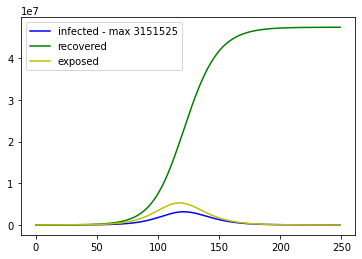

In [4]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230
I0 = 2209
R0 = 0
E0 = 0
time_range = range(250)
r0, dur_inf, dur_inc = (1.9, 3.61, 5.95)
plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc)

### calibrate to italian case

calibrating with genetic algorithm...
r0 4.922701021512119
infection period in days 14.65067489475256
incubation period in days 1.0012351457310558
mae  8592
max number of infections  27259629
peak of infections  61
max number of exposed  3172857
max number of recovered  61368833


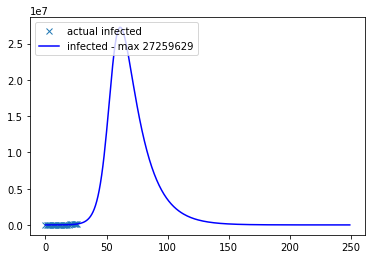

In [10]:
cases_multiplier = 3
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230# 60431283
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = cases_multiplier * df['totale_attualmente_positivi'].values
R0 = 0
E0 = 0
time_range = range(250)
r0, dur_inf, dur_inc = calibrate_SEIR(y_fit = y_fit,               
                                      N = N,
                                      I0 = I0,
                                      R0 = R0,
                                      E0 = E0,
                                      time_horizon = 365,
                                      bounds= [(0,5), (1, 30), (1, 30)],
                                      use_differential_evolution = True)
plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc, y_fit)

In [19]:
S0 = N - I0 - R0 - E0
CFR = 0.05
total_deaths = integrate.quad(lambda x: CFR*SEIRModel((x,), S0, E0, I0, R0, r0, dur_inf, dur_inc)[2], 0, 250)[0]

print('total ', total_deaths)

total  8287.5


In [161]:
def func(y, t, N, I0, R0, D_incubation, D_infectious, D_recovery_mild, 
         D_hospital_lag, D_recovery_severe, D_death, P_SEVERE, CFR, 
         InterventionTime, InterventionAmt, duration):
    
    interpolation_steps = 40
    steps = 110*interpolation_steps
    dt = dt/interpolation_steps
    sample_step = interpolation_steps
# SEIR ODE
    if (t > InterventionTime & t < InterventionTime + duration):
        beta = (InterventionAmt)*R0/(D_infectious)
    elif(t > InterventionTime + duration):
        beta = 0.5*R0/(D_infectious)        
    else:
        beta = R0/(D_infectious)

    a     = 1/D_incubation
    gamma = 1/D_infectious

    S         = y[0] # Susectable
    E         = y[1] # Exposed
    I         = y[2] # Infectious 
    Mild      = y[3] # Recovering (Mild)     
    Severe    = y[4] # Recovering (Severe at home)
    Severe_H  = y[5] # Recovering (Severe in hospital)
    Fatal     = y[6] # Recovering (Fatal)
    R_Mild    = y[7] # Recovered
    R_Severe  = y[8] # Recovered
    R_Fatal   = y[9] # Dead
    p_severe  = P_SEVERE
    p_fatal   = CFR
    p_mild    = 1 - P_SEVERE - CFR
    dS        = -beta*I*S
    dE        =  beta*I*S - a*E
    dI        =  a*E - gamma*I
    dMild     =  p_mild*gamma*I   - (1/D_recovery_mild)*Mild
    dSevere   =  p_severe*gamma*I - (1/D_hospital_lag)*Severe
    dSevere_H =  (1/D_hospital_lag)*Severe - (1/D_recovery_severe)*Severe_H
    dFatal    =  p_fatal*gamma*I  - (1/D_death)*Fatal
    dR_Mild   =  (1/D_recovery_mild)*Mild
    dR_Severe =  (1/D_recovery_severe)*Severe_H
    dR_Fatal  =  (1/D_death)*Fatal
    
    return dS, dE, dI, dMild, dSevere, dSevere_H, dFatal, dR_Mild, dR_Severe, dR_Fatal

In [23]:
#https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

In [28]:
# Define parameters
t_max = 100
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2
beta = 1.75
gamma = 0.5
params = alpha, beta, gamma
# Run simulation
results = base_seir_model(init_vals, params, t)

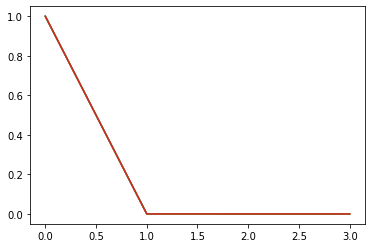

In [29]:
plt.plot(results[0], label='S')
plt.plot(results[1], label='E')
plt.plot(results[2], label='I')
plt.plot(results[3], label='R')